# Title

Author: Sandra Godinho Silva \
Most updated version: 0.1 (1/01/2021)

## Purpose
State the purpose of the notebook.

## Methodology
Quickly describe assumptions and processing steps.

## WIP - improvements
Use this section only if the notebook is not final.

Notable TODOs:
- todo 1;
- todo 2;
- todo 3.

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import
We import all the required Python libraries

In [1]:
###############################################################################
#                          1. Importing Libraries                             #
###############################################################################
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import plotly.express as px

## Local library import
We import all the required local libraries libraries

In [3]:
import sys

In [4]:
import numpy as np
from sklearn import model_selection

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import label_binarize


from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV,   GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold

from sklearn.feature_selection import RFE, RFECV


from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_auc_score, matthews_corrcoef, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.linear_model import LogisticRegression

import numpy as np

from sklearn.svm import SVC

from sklearn.multiclass import OneVsRestClassifier

# Parameter definition
We set all relevant parameters for our notebook. By convention, parameters are uppercase, while all the 
other variables follow Python's guidelines.

In [5]:
num_runs = 1 #int(config.get('Evaluation', 'NumberRuns'))
num_test = 3
normalization = "Standard"

train_rf = "True"
train_logistic_regression = "False"
train_svm = "False"

# RF
NumberTrees = 500 
ValidationModels =  5

# SVM
GridCV = 5
MaxIterations = 1000
max_iter = MaxIterations

num_cv=2

In [6]:
to_train = []

if train_rf == "True":
    to_train.append("RF")
if train_logistic_regression == "True":
    to_train.append("Logistic Regression")
if train_svm == "True":
    to_train.append("SVM")
    
# Set up DataFrames to store results
cv_list = ["Run_" + str(x) + "_CV_" + str(y) for x in range(num_runs) for y in range(num_test)]
auc_df = pd.DataFrame(index=to_train, columns=cv_list)
mcc_df = pd.DataFrame(index=to_train, columns=cv_list)
precision_df = pd.DataFrame(index=to_train, columns=cv_list)
recall_df = pd.DataFrame(index=to_train, columns=cv_list)
f1_df = pd.DataFrame(index=to_train, columns=cv_list)

# Functions

In [7]:
# Hyperparameter tunning for Random Forest
def parameter_tunning_RF():
    # number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
    
    # number of features at every split
    max_features = ["auto", "sqrt"]

    # max depth
    max_depth = [int(x) for x in np.linspace(100, 500, num = 11)]
    max_depth.append(None)
    
    # create random grid
    random_grid = {
     "n_estimators": n_estimators,
     "max_features": max_features,
     "max_depth": max_depth
     }
    
    rfc = RandomForestClassifier()
    # Random search of parameters
    #In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings 
    #is sampled from the specified distributions. The number of parameter settings that are tried is given by n_iter.
    rfc_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    # Fit the model
    rfc_random.fit(X_train, y_train)
       
    best_parameters = rfc_random.best_params_
    print(best_parameters)
    
    return best_parameters

In [8]:
def get_stats(y_test, pred, fitted):
    stat_dict = {}
    stat_dict["Accuracy"] = accuracy_score(y_test, pred)
    stat_dict["MCC"] = matthews_corrcoef(y_test, pred)
    stat_dict["Precision"] = precision_score(y_test, pred, average='weighted')
    stat_dict["Recall"] = recall_score(y_test, pred, average='weighted')
    stat_dict["F1"] = f1_score(y_test, pred, average='weighted')

    #Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    if num_class == 2:
        stat_dict["AUC"] = roc_auc_score(y_test, fitted.predict_proba(X_test)[:,1], average='weighted')
    else:
        stat_dict["AUC"] = roc_auc_score(y_test, fitted.predict_proba(X_test), average='weighted')   
    
    return stat_dict

In [9]:
def generate_boxplot(): #to_train, num_class, auc_df, mcc_df, precision_df, recall_df, f1_df, results_path

    fig = px.box(pd.melt(auc_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of AUC",
             labels={"value": "AUC",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(mcc_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of MMC",
             labels={"value": "MMC",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(precision_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of Precision measure",
             labels={"value": "Precision",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(recall_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of Recall measure",
             labels={"value": "Recall",
                     "variable": "Model"})
    fig.show()
    
    fig = px.box(pd.melt(f1_df.transpose()), x="variable", y="value", 
             color="variable",
             title="Box plot of F1",
             labels={"value": "F1",
                     "variable": "Model"})
    fig.show()
    


# Data import
We retrieve all the required data for the analysis.

In [10]:
#df = pd.read_csv("cog_genus_counts.csv", index_col=0)
df=pd.read_csv("cazymes_PA_metadata.csv")
df.head()

,GT2_Glycos_transf_2,GT9,GT4,GT5,GT25,GH30_1,GH3,GH144,GT51,GH25,CBM50+GH73,CBM32+GH2,GH2,GH109,GT19,GT83,CE11,GH13,GH65,GH97,GH13_19,GT2,CE14,GH92,GT28,...,GH92+GH92,CBM3+GH74,GH5_36,GH102,GH18+CBM6,GH16+GT25,GH123+GH123,CBM35+CBM57+CBM6,CE4+GT2_Glycos_transf_2,GH20+CBM32+CBM5,CE1+CE1,GH39+CBM6,GH81,AA4,CBM32+PL6,CBM77,CBM6+GH3,GH51+CBM35,GH18+CBM73,CBM32+PL7_5,PL7_5+4.2.2.3,CBM47+PL7_3,CBM16+CBM47+PL7_3,CBM47+CBM6+CBM47+CBM6,Origin
0,1,1,1,1,0,0,1,0,1,0,1,0,1,1,1,0,1,0,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Non_marine
1,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marine
2,1,1,1,1,0,0,1,0,1,0,1,0,0,0,1,1,1,1,1,0,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marine
3,1,1,1,1,0,1,1,1,1,0,0,0,1,0,1,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Marine
4,1,0,1,1,0,1,1,0,1,0,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Non_marine


In [32]:
category= "Origin"
X = df.copy()
y = X.pop(category).values

# Stratified k-fold needs np arrays
X = X.to_numpy()

In [12]:
labels=df.drop(columns=category).columns
labels_data, label_set = pd.factorize(labels)
label_set

Index(['GT2_Glycos_transf_2', 'GT9', 'GT4', 'GT5', 'GT25', 'GH30_1', 'GH3',
       'GH144', 'GT51', 'GH25',
       ...
       'CBM32+PL6', 'CBM77', 'CBM6+GH3', 'GH51+CBM35', 'GH18+CBM73',
       'CBM32+PL7_5', 'PL7_5+4.2.2.3', 'CBM47+PL7_3', 'CBM16+CBM47+PL7_3',
       'CBM47+CBM6+CBM47+CBM6'],
      dtype='object', length=749)

In [13]:
features = df.select_dtypes(include=['int']).columns
num_class = len(np.unique(y))

rf_scores = pd.DataFrame(index=features)

if num_class == 2:
    svm_scores = pd.DataFrame(index=features)
    logistic_regression_scores = pd.DataFrame(index=features)

else:
    svm_scores = {}
    logistic_regression_scores = {}
    for l in label_set:
        svm_scores[l] = pd.DataFrame(index=features)     
        logistic_regression_scores[l] = pd.DataFrame(index=features) 

# 1. Filter Method: Correlation-Based Feature Selection

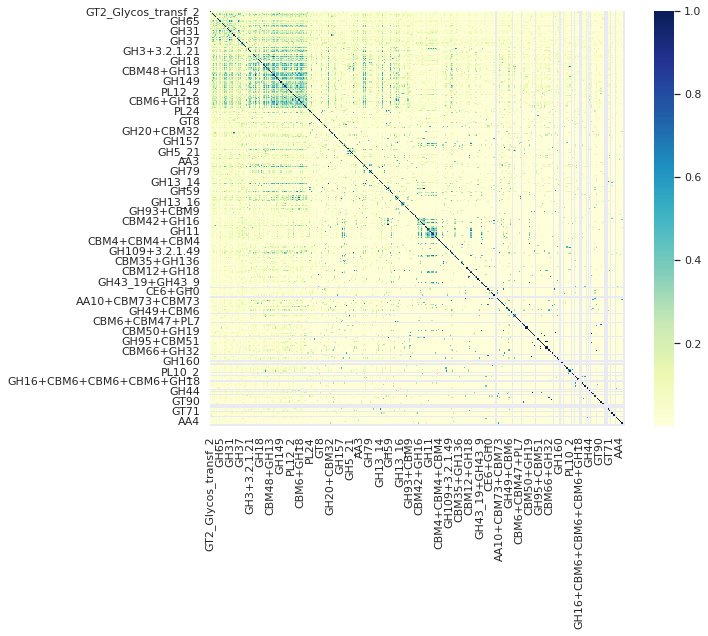

In [34]:
category= "Origin"
X = df.copy()
y = X.pop(category).values

###############################################################################
#                        3. Create train and test set                         #
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)
print(X_train.shape)
###############################################################################
#              6. Feature Selection: Removing highly correlated features      #
###############################################################################
# Filter Method: Spearman's Cross Correlation > 0.95
# Make correlation matrix
corr_matrix = X_train.corr(method = "spearman").abs()

# Draw the heatmap
sns.set(font_scale = 1.0)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(corr_matrix, cmap= "YlGnBu", square=True, ax = ax)
f.tight_layout()
plt.savefig("correlation_matrix.png", dpi = 1080)

# Select upper triangle of matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k = 1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_train = X_train.drop(to_drop, axis = 1)
X_test = X_test.drop(to_drop, axis = 1)


In [36]:
print(to_drop)

['CBM6+GH18', 'CBM6+GH43_16', 'PL27', 'GH20+CBM32', 'CBM48+GH13_10', 'CBM16+GH16+3.2.1.83', 'GH130+2.4.1.-', 'GH5_1', 'CBM26+GH13_19+GH13_6', 'CBM5', 'CBM47+CBM6+CBM35', 'GH76+3.2.1.101', 'GH88+PL8_3', 'CBM16+PL7_3', 'GH27+CBM51', 'CBM10+CBM13+CBM35+PL11_1', 'CBM32+CBM6+GH81', 'PL36_1', 'CE12+CE12', 'GH159', 'GH43_24+GH43_17', 'GH13_10', 'PL11_2', 'CBM66', 'GH95+CBM51', 'CBM32+CBM51+GH2', 'CBM6+CBM13', 'GH43_26+CBM6+CBM13', 'CBM13+GH5_4', 'CBM13+GH29', 'CE6+CBM6', 'CBM57+GH43_2', 'CE1+CBM6', 'CBM66+GH32', 'CBM61+GH53', 'GH135', 'GH62', 'GH48', 'GH120+CBM6', 'CBM2', 'GH144+GH29', 'GH88+3.2.1.-', 'GH74+CBM2', 'GT25+GH16', 'GH18+CBM73']


In [14]:
normalization="Standard"
num_test=3
seeds = np.random.randint(1000, size=num_runs)
run = 0

for seed in seeds:
    print("Starting CV")
    #Provides train/test indices to split data in train/test sets.
    skf = StratifiedKFold(n_splits=num_test, shuffle=True, random_state=seed)
    fold = 0
    
    # Hypertunning before K folds - Random Forest
    try: # If it was run before, don't run again
        best_rf_parameters
    except:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=66)
        best_rf_parameters = parameter_tunning_RF()
    print("RandomSearchCV best parameters for Random Forest: " + str(best_rf_parameters))
    
    # Stratified k-fold
    for train_index, test_index in skf.split(X, y):
        # Select and format training and testing sets
        X_train, X_test = X[train_index,:], X[test_index,:]
        y_train, y_test = y[train_index], y[test_index]
        
        cl =  np.unique(y_train)
        num_class = len(cl)
        
        ###################################################################################
        # RANDOM FOREST
        if train_rf == "True":
        # Already use best parameters from Hyperparameter tunning
            rfc = RandomForestClassifier(n_estimators=best_rf_parameters["n_estimators"], 
                                         max_features=best_rf_parameters["max_features"], 
                                         max_depth=best_rf_parameters["max_depth"])

            # Fit model
            rfc.fit(X_train,y_train)
        
            # Get predicted labels for the test data:
            rfc_predict = rfc.predict(X_test)

            # Get ranking of feature importance
            feature_importance = rfc.feature_importances_
        
            stat_dict = get_stats(y_test, rfc_predict, rfc)
            
            rf_scores["Run_" + str(run) + "_CV_" + str(fold)] = feature_importance
        
            auc_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["AUC"]
            mcc_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["MCC"]
            precision_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["Precision"]
            recall_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["Recall"]
            f1_df.loc["RF"]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict["F1"]

            sys.stdout.write("")
            print("# RF:\t\t\t%f\t%f" % (stat_dict["AUC"], auc_df.loc["RF"].mean(axis=0)))    
    
        fold +=1
    run +=1

Starting CV
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:   46.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished


{'n_estimators': 800, 'max_features': 'auto', 'max_depth': 380}
RandomSearchCV best parameters for Random Forest: {'n_estimators': 800, 'max_features': 'auto', 'max_depth': 380}
# RF:			0.919682	0.919682
# RF:			0.900463	0.910072
# RF:			0.925721	0.915289


In [15]:
auc_df.to_csv("Evaluation_dfs/auc_df.csv")
mcc_df.to_csv("Evaluation_dfs/mcc_df.csv")
precision_df.to_csv("Evaluation_dfs/precision_df.csv")
recall_df.to_csv("Evaluation_dfs/recall_df.csv")
f1_df.to_csv("Evaluation_dfs/f1_df.csv")

In [16]:
###############################################################################
#                          X. Choosing best model                             #
###############################################################################

results_df = pd.DataFrame(index=["AUC", "MCC", "Precision", "Recall", "F1"], columns=to_train)
results_df_nr = pd.DataFrame(index=["AUC", "MCC", "Precision", "Recall", "F1"], columns=to_train)

for model in to_train:
    results_df.loc["AUC"][model] = "{:.2f}".format(auc_df.loc[model].mean())+ " (" + "{:.2f}".format(auc_df.loc[model].std()) + ")"     
    results_df_nr.loc["AUC"][model] = auc_df.loc[model].mean()   
    
    results_df.loc["MCC"][model] = "{:.2f}".format(mcc_df.loc[model].mean()) + " (" + "{:.2f}".format(mcc_df.loc[model].std()) + ")"
    results_df_nr.loc["MCC"][model] = mcc_df.loc[model].mean()   
    
    results_df.loc["Precision"][model] = "{:.2f}".format(precision_df.loc[model].mean()) + " (" + "{:.2f}".format(precision_df.loc[model].std()) + ")"
    results_df_nr.loc["Precision"][model] = precision_df.loc[model].mean()   

    results_df.loc["Recall"][model] = "{:.2f}".format(recall_df.loc[model].mean()) + " (" + "{:.2f}".format(recall_df.loc[model].std()) + ")"
    results_df_nr.loc["Recall"][model] = recall_df.loc[model].mean()   

    results_df.loc["F1"][model] = "{:.2f}".format(f1_df.loc[model].mean()) + " (" + "{:.2f}".format(f1_df.loc[model].std()) + ")"
    results_df_nr.loc["F1"][model] = f1_df.loc[model].mean()   

# Find model with best metrics    
results_df_nr.loc["Total",:] = results_df_nr.sum(axis=0).divide(5).round(2)

best={}
for model in to_train:
    best[model] = results_df_nr.loc["Total",:][model]
    
best_model = max(best, key=best.get)

print("Results - mean & standard deviation values per model: ")
print(results_df.head(20))
print("")
print("Best model: " + str(best_model))

results_df.to_csv("Evaluation_dfs/results.csv")

Results - mean & standard deviation values per model: 
                    RF
AUC        0.92 (0.01)
MCC        0.73 (0.01)
Precision  0.87 (0.01)
Recall     0.87 (0.01)
F1         0.87 (0.01)

Best model: RF


In [17]:
ranking_df = pd.DataFrame(index=range(len(features)))

rf_ranking_df = pd.DataFrame(index=range(len(features)))
svm_ranking_df = pd.DataFrame(index=range(len(features)))

model_rankings = {}

if "RF" in to_train:
    for col in rf_scores.columns:
        rank_list = rf_scores[col].rank(ascending=False).sort_values(ascending=True).index.values
        ranking_df["RF_" + col] = rank_list
        rf_ranking_df["RF_" + col] = rank_list

        model_rankings["RF"] = rf_scores.median(axis=1).sort_values(ascending=False).index.values
            

<AxesSubplot:>

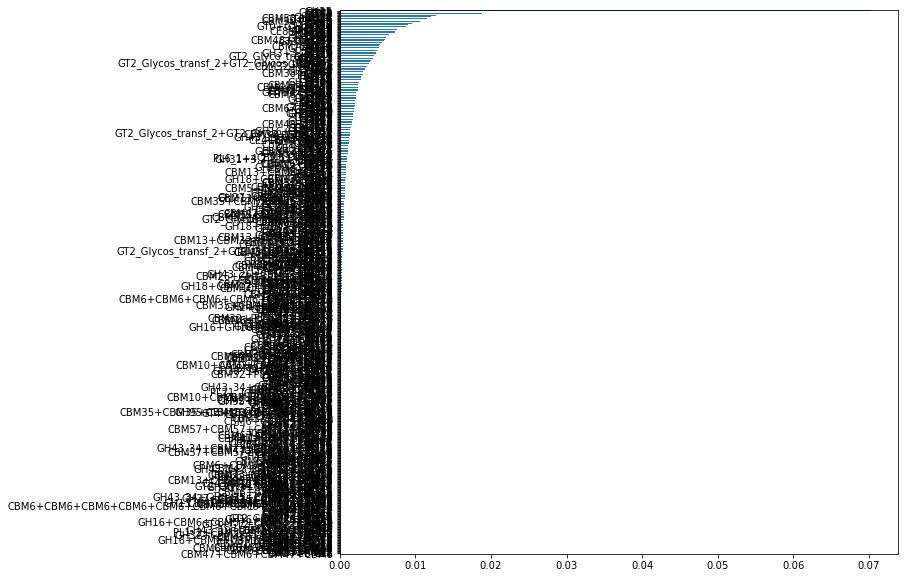

In [18]:
rf_scores.median(axis=1).sort_values(ascending=True).plot(kind="barh", figsize=(10,10))

In [19]:
if "RF" in to_train:
    rf_ranking_df.to_csv("Evaluation_dfs/rf_feature_ranks.csv")
    rf_scores.to_csv("Evaluation_dfs/rf_feature_scores.csv")
    np.savetxt("Evaluation_dfs/rf_rank_list.txt", model_rankings["RF"], fmt="%s")

In [20]:
rf_ranking_df

,RF_Run_0_CV_0,RF_Run_0_CV_1,RF_Run_0_CV_2
0,GH25,GH25,GH25
1,GH113,GH113,GH113
2,GT83,CBM9,GT83
3,CBM9,CE4,CBM9
4,CE4,GT83,GH15
...,...,...,...
744,CBM6+GH27+GH43_29,CE10+CE1,CBM32+GH3
745,GH141+CBM16,GH28+GH43,CBM4+CBM4
746,GT2_Glyco_tranf_2_4,CBM13+GH5_4,CBM47+GH111+CBM47
747,CBM6+CBM6+CBM6+CBM6,PL30,GH62


In [21]:
# Feature Selection implementation
if best_model == "RF":
    rfc = RandomForestClassifier(n_estimators=best_rf_parameters["n_estimators"], 
                                         max_features=best_rf_parameters["max_features"], 
                                         max_depth=best_rf_parameters["max_depth"])
    # Fit model
    rfc.fit(X_train,y_train)    
    
    # Get predicted labels for the test data:
    rfc_predict = rfc.predict(X_test)

    # Cross-validation
    scores = cross_val_score(rfc, X, y, cv=5)
    print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))
    
    # Get ranking of feature importance
    feature_importance = rfc.feature_importances_
        
    stat_dict_final = get_stats(y_test, rfc_predict, rfc)

        
rf_scores["Run_" + str(run) + "_CV_" + str(fold)] = feature_importance
        
auc_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["AUC"]
mcc_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["MCC"]
precision_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["Precision"]
recall_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["Recall"]
f1_df.loc[best_model]["Run_" + str(run) + "_CV_" + str(fold)]=stat_dict_final["F1"]

sys.stdout.write("")
print(str(best_model) + " AUC: " + str(stat_dict_final["AUC"]))

0.88 accuracy with a standard deviation of 0.01
RF AUC: 0.9236593364197531


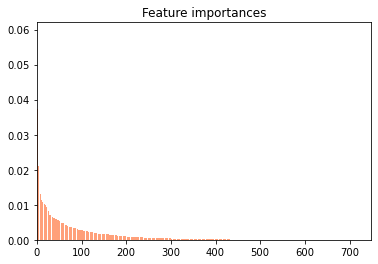

In [22]:
import matplotlib.pyplot as plt
rf = RandomForestClassifier(n_estimators = 100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
        color="lightsalmon", align="center")
#plt.xticks(range(X_train.shape[1]), X_train.feature_names[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

(1004, 749)
Automatically created module for IPython interactive environment


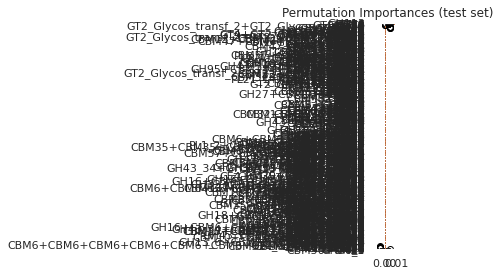

In [39]:
category= "Origin"
X = df.copy()
y = X.pop(category).values

###############################################################################
#                        3. Create train and test set                         #
###############################################################################
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20,
                                                    random_state = 1000)
print(X_train.shape)
print(__doc__)


import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
result = permutation_importance(rfc, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

In [40]:
from sklearn.feature_selection import RFECV

min_features_to_select = 1  # Minimum number of features to consider

rfecv = RFECV(estimator=rfc, 
              step=1, 
              cv=StratifiedKFold(2),
              scoring='accuracy',
              n_jobs=-1,
              min_features_to_select=min_features_to_select)

rfecv.fit(X, y)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(max_depth=380, n_estimators=800),
      n_jobs=-1, scoring='accuracy')

Optimal number of features : 483


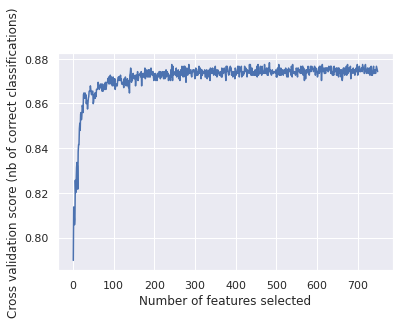

In [41]:
print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(min_features_to_select,
               len(rfecv.grid_scores_) + min_features_to_select),
         rfecv.grid_scores_)
plt.show()

In [42]:
# Get selected features labels
feature_names = df.columns
selected_features = feature_names[feature_selector.support_].tolist()

NameError: name 'feature_selector' is not defined

In [ ]:
generate_boxplot()

In [ ]:
ranking_df = pd.DataFrame(index=range(len(features)))

rf_ranking_df = pd.DataFrame(index=range(len(features)))
svm_ranking_df = pd.DataFrame(index=range(len(features)))

model_rankings = {}
        
if "RF" in to_train:
    for col in rf_scores.columns:
        rank_list = rf_scores[col].rank(ascending=False).sort_values(ascending=True).index.values
        ranking_df["RF_" + col] = rank_list
        rf_ranking_df["RF_" + col] = rank_list
    model_rankings["RF"] = rf_scores.median(axis=1).sort_values(ascending=False).index.values

In [ ]:

    import matplotlib.pyplot as plt
    import seaborn as sns
    if "RF" in to_train:
        rf_median_scores = rf_scores.median(axis=1)        
        fig = plt.figure(dpi=300, figsize=(9,9), tight_layout=True)
        
        plt.ylabel("Density")
        plt.xlabel("Score")
        plt.title("RF Feature Scores")
        sns.distplot(list(rf_median_scores))
        plt.savefig("RF_scores.png")
        #plt.clf()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
def generate_score_distributions():

    if "RF" in to_train:
        rf_median_scores = rf_scores.median(axis=1)        
        fig = plt.figure(dpi=300, figsize=(9,9), tight_layout=True)
        
        plt.ylabel("Density")
        plt.xlabel("Score")
        plt.title("RF Feature Scores")
        sns.distplot(list(rf_median_scores))
        plt.savefig("RF_scores.png")
        #plt.clf()

    if "SVM" in to_train:
        fig = plt.figure(dpi=300, figsize=(9,9), tight_layout=True)

        plt.ylabel("Density")
        plt.xlabel("Score")
        plt.title("SVM Feature Scores")
        if num_class == 2:
            svm_median_scores = svm_scores.median(axis=1).values
            sns.distplot(svm_median_scores)
        else:
            for l in label_set:
                svm_median_scores = svm_scores[l].median(axis=1).values  
                sns.distplot(svm_median_scores, label=str(l).title())
            plt.legend()
        plt.savefig("SVM_scores.png")
        #plt.clf()

    return

generate_score_distributions()